# Classical Malay Text Transliteration with KerasNLP

**Author:** [Aiman Adam](https://github.com/chuckskakap)<br>
**Date created:** 2023/11/17<br>
**Last modified:** 2023/11/17<br>
**Description:** Use KerasNLP to train a sequence-to-sequence Transformer model on the machine translation task.

## Introduction
I used:

- Tokenize text using `keras_nlp.tokenizers.WordPieceTokenizer`.
- Implement a sequence-to-sequence Transformer model using KerasNLP's
`keras_nlp.layers.TransformerEncoder`, `keras_nlp.layers.TransformerDecoder` and
`keras_nlp.layers.TokenAndPositionEmbedding` layers, and train it.
- Use `keras_nlp.samplers` to generate translations of unseen input sentences
 using the top-p decoding strategy!


## Setup


In [1]:
import keras_nlp
import pathlib
import random
import tensorflow as tf
import pickle

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow_text.tools.wordpiece_vocab import (
    bert_vocab_from_dataset as bert_vocab,
)

Using TensorFlow backend


Let's also define our parameters/hyperparameters.

In [2]:
BATCH_SIZE = 64
EPOCHS = 30
MAX_SEQUENCE_LENGTH = 40
JW_VOCAB_SIZE = 15000
RM_VOCAB_SIZE = 15000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

## Import the data

I used be a Jawi-to-Rumi transliteration dataset
provided by Akademi Jawi Malaysia Sdn Bhd (Nirnama)

In [3]:
text_file = "jawi-rumi.txt"

## Parsing the data

Each line contains an Jawi sentence and its corresponding Rumi sentence.
The Jawi sentence is the *source sequence* and Rumi one is the *target sequence*.
Before adding the text to a list, we convert it to lowercase.

In [4]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    jw, rm = line.split("\t")
    jw = jw.lower().strip()
    rm = rm.lower().strip()
    text_pairs.append((jw, rm))

Here's what our sentence pairs look like:

In [5]:
for _ in range(5):
    print(random.choice(text_pairs))

('تاڠن ايت سڬرا دسمبوت', 'tangan itu segera disambut')
('امڤونكن اكو واهاي بودق', 'ampunkan aku wahai budak')
('دي مميجق اڠين كليهتن سڤرتي سدڠ منداكي تڠݢ لوتسينر', 'dia memijak angin kelihatan seperti sedang mendaki tangga lutsinar')
('تتاڤي اديواج تيدق كليهتن ساكيت', 'tetapi adiwaja tidak kelihatan sakit')
('مالڠ بلوم سمڤت دي برڬرق نيرنام سوده براد دأتسڽ', 'malang belum sempat dia bergerak nirnama sudah berada di atasnya')


Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [6]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")


13573 total pairs
9503 training pairs
2035 validation pairs
2035 test pairs


## Tokenizing the data

We'll define two tokenizers - one for the source language (Jawi), and the other
for the target language (Rumi). I used
`keras_nlp.tokenizers.WordPieceTokenizer` to tokenize the text.
`keras_nlp.tokenizers.WordPieceTokenizer` takes a WordPiece vocabulary
and has functions for tokenizing the text, and detokenizing sequences of tokens.

Before we define the two tokenizers, we first need to train them on the dataset
we have. The WordPiece tokenization algorithm is a subword tokenization algorithm;
training it on a corpus gives us a vocabulary of subwords. A subword tokenizer
is a compromise between word tokenizers (word tokenizers need very large
vocabularies for good coverage of input words), and character tokenizers
(characters don't really encode meaning like words do). Luckily, KerasNLP
makes it very simple to train WordPiece on a corpus with the
`keras_nlp.tokenizers.compute_word_piece_vocabulary` utility.

In [7]:

def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab


Every vocabulary has a few special, reserved tokens. We have four such tokens:

- `"[PAD]"` - Padding token. Padding tokens are appended to the input sequence
length when the input sequence length is shorter than the maximum sequence length.
- `"[UNK]"` - Unknown token.
- `"[START]"` - Token that marks the start of the input sequence.
- `"[END]"` - Token that marks the end of the input sequence.

In [8]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

jw_samples = [text_pair[0] for text_pair in train_pairs]
jw_vocab = train_word_piece(jw_samples, JW_VOCAB_SIZE, reserved_tokens)

rm_samples = [text_pair[1] for text_pair in train_pairs]
rm_vocab = train_word_piece(rm_samples, RM_VOCAB_SIZE, reserved_tokens)

In [9]:
# Save jw_vocab
with open('jw_vocab.pkl', 'wb') as f:
    pickle.dump(jw_vocab, f)

# Save rm_vocab
with open('rm_vocab.pkl', 'wb') as f:
    pickle.dump(rm_vocab, f)


Sample tokens

In [10]:
print("Jawi Tokens: ", jw_vocab[100:105])
print("Rumi Tokens: ", rm_vocab[100:105])
print("Rumi Tokens: ", len(jw_vocab))
print("Rumi Tokens: ", len(rm_vocab))

Jawi Tokens:  ['تاڠن', 'ڤوتيه', '##ا', 'تنترا', 'سوده']
Rumi Tokens:  ['besar', 'semua', 'masih', 'memandang', '##t']
Rumi Tokens:  1933
Rumi Tokens:  1750


Define the tokenizers. Cconfigure the tokenizers with the
the vocabularies trained above.

In [11]:
jw_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=jw_vocab, lowercase=False
)
rm_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=rm_vocab, lowercase=False
)

Tokenize a sample from the dataset. To verify whether the text has
been tokenized correctly, it must also detokenize the list of tokens back to the
original text.

In [12]:
jw_input_ex = text_pairs[10][0]
jw_tokens_ex = jw_tokenizer.tokenize(jw_input_ex)
print("Jawi sentence: ", jw_input_ex)
print("Tokens: ", jw_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    jw_tokenizer.detokenize(jw_tokens_ex),
)

print()

rm_input_ex = text_pairs[10][1]
rm_tokens_ex = rm_tokenizer.tokenize(rm_input_ex)
print("Rumi sentence: ", rm_input_ex)
print("Tokens: ", rm_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    rm_tokenizer.detokenize(rm_tokens_ex),
)

Jawi sentence:  نيرنام ممندڠ چندانا دان مڠڠڬوق تندا تريما كاسيه
Tokens:  tf.Tensor([ 62 129  75  60 204 679 492 521], shape=(8,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'\xd9\x86\xd9\x8a\xd8\xb1\xd9\x86\xd8\xa7\xd9\x85 \xd9\x85\xd9\x85\xd9\x86\xd8\xaf\xda\xa0 \xda\x86\xd9\x86\xd8\xaf\xd8\xa7\xd9\x86\xd8\xa7 \xd8\xaf\xd8\xa7\xd9\x86 \xd9\x85\xda\xa0\xda\xa0\xda\xac\xd9\x88\xd9\x82 \xd8\xaa\xd9\x86\xd8\xaf\xd8\xa7 \xd8\xaa\xd8\xb1\xd9\x8a\xd9\x85\xd8\xa7 \xd9\x83\xd8\xa7\xd8\xb3\xd9\x8a\xd9\x87', shape=(), dtype=string)

Rumi sentence:  nirnama memandang cendana dan mengangguk tanda terima kasih
Tokens:  tf.Tensor([ 34 103  49  32 189 673 492 502], shape=(8,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'nirnama memandang cendana dan mengangguk tanda terima kasih', shape=(), dtype=string)


In [15]:
jw_input_ex = 'ماتڽ تاجم'
jw_tokens_ex = jw_tokenizer.tokenize(jw_input_ex)
print("Rumi sentence: ", jw_input_ex)
print("Tokens: ", jw_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    jw_tokenizer.detokenize(jw_tokens_ex),
)

Rumi sentence:  ماتڽ تاجم
Tokens:  tf.Tensor([294 515], shape=(2,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'\xd9\x85\xd8\xa7\xd8\xaa\xda\xbd \xd8\xaa\xd8\xa7\xd8\xac\xd9\x85', shape=(), dtype=string)


In [19]:
print("Rumi sentence:  ماتڽ تاجم")
print("Tokens:  tf.Tensor([294 515], shape=(2,), dtype=int32)")
print("Recovered text after detokenizing:  tf.Tensor(b'\xd9\x85\xd8\xa7\xd8\xaa\xda\xbd")
print(" \xd8\xaa\xd8\xa7\xd8\xac\xd9\x85', shape=(), dtype=string)")


Rumi sentence:  ماتڽ تاجم
Tokens:  tf.Tensor([294 515], shape=(2,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'ÙØ§ØªÚ½
 ØªØ§Ø¬Ù', shape=(), dtype=string)


## Format datasets

Format the datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`encoder_inputs` is the tokenized source sentence and `decoder_inputs` is the target
sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target
sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

Add special tokens, `"[START]"` and `"[END]"`, to the input Rumi
sentence after tokenizing the text. We will also pad the input to a fixed length.
This can be easily done using `keras_nlp.layers.StartEndPacker`.

In [25]:

def preprocess_batch(jw, rm):
    batch_size = tf.shape(rm)[0]

    jw = jw_tokenizer(jw)
    rm = rm_tokenizer(rm)

    # Pad `jw` to `MAX_SEQUENCE_LENGTH`.
    jw_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=jw_tokenizer.token_to_id("[PAD]"),
    )
    jw = jw_start_end_packer(jw)

    # Add special tokens (`"[START]"` and `"[END]"`) to `rm` and pad it as well.
    rm_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=rm_tokenizer.token_to_id("[START]"),
        end_value=rm_tokenizer.token_to_id("[END]"),
        pad_value=rm_tokenizer.token_to_id("[PAD]"),
    )
    rm = rm_start_end_packer(rm)

    return (
        {
            "encoder_inputs": jw,
            "decoder_inputs": rm[:, :-1],
        },
        rm[:, 1:],
    )


def make_dataset(pairs):
    jw_texts, rm_texts = zip(*pairs)
    jw_texts = list(jw_texts)
    rm_texts = list(rm_texts)
    dataset = tf.data.Dataset.from_tensor_slices((jw_texts, rm_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 40 steps long):

In [26]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")


inputs["encoder_inputs"].shape: (64, 40)
inputs["decoder_inputs"].shape: (64, 40)
targets.shape: (64, 40)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


In [28]:
jawi_sentence_lengths = [len(sentence.split()) for sentence in jw_samples]
rumi_sentence_lengths = [len(sentence.split()) for sentence in rm_samples]


In [29]:
print(max(jawi_sentence_lengths))
print(max(rumi_sentence_lengths))

56
68


In [51]:
print((jawi_sentence_lengths))
print((rumi_sentence_lengths))

[5, 6, 13, 16, 7, 28, 16, 14, 7, 5, 7, 2, 11, 4, 14, 12, 7, 8, 7, 15, 7, 3, 3, 10, 5, 13, 3, 9, 2, 19, 11, 6, 5, 2, 2, 9, 15, 3, 4, 5, 11, 8, 4, 7, 4, 16, 25, 15, 11, 8, 4, 3, 10, 11, 9, 6, 5, 3, 4, 10, 17, 4, 13, 16, 3, 8, 9, 5, 6, 12, 3, 6, 7, 19, 15, 14, 15, 3, 14, 7, 7, 12, 3, 26, 6, 1, 5, 6, 20, 4, 2, 11, 4, 8, 9, 6, 4, 9, 14, 7, 2, 12, 10, 6, 2, 4, 3, 5, 9, 7, 11, 12, 4, 2, 12, 3, 18, 10, 9, 13, 15, 30, 9, 10, 11, 11, 6, 4, 4, 8, 2, 7, 12, 13, 14, 23, 2, 4, 9, 3, 13, 17, 16, 7, 16, 5, 10, 9, 1, 4, 10, 6, 20, 4, 19, 8, 8, 5, 10, 13, 9, 1, 18, 7, 6, 5, 23, 12, 22, 11, 8, 3, 5, 3, 4, 16, 10, 6, 15, 3, 2, 6, 4, 16, 3, 9, 2, 12, 11, 3, 5, 14, 12, 2, 39, 5, 17, 4, 4, 8, 10, 10, 11, 7, 8, 5, 19, 5, 5, 6, 1, 15, 4, 19, 4, 5, 4, 9, 7, 16, 10, 10, 6, 2, 6, 3, 11, 10, 19, 3, 10, 7, 13, 2, 14, 7, 11, 10, 5, 3, 1, 13, 12, 13, 10, 10, 6, 10, 13, 10, 2, 12, 4, 5, 8, 6, 5, 8, 4, 2, 2, 10, 5, 18, 4, 16, 5, 19, 4, 9, 19, 7, 20, 17, 19, 9, 5, 2, 7, 12, 4, 8, 14, 24, 3, 2, 15, 3, 6, 7, 7, 5, 7, 6, 2

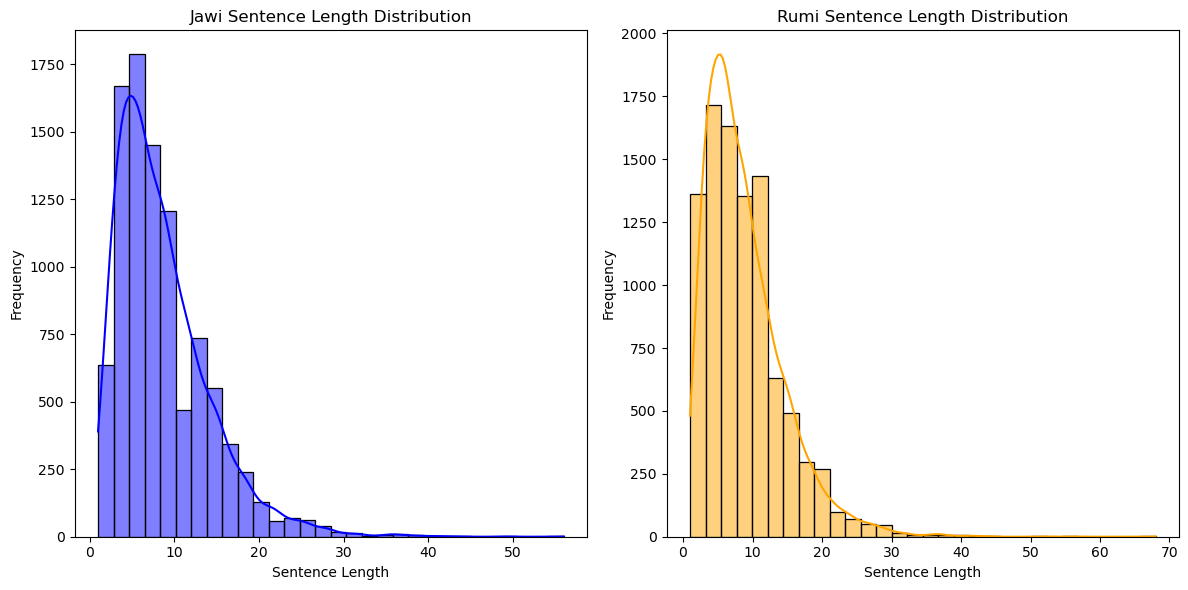

In [30]:
plt.figure(figsize=(12, 6))

# Jawi Sentence Length Distribution
plt.subplot(1, 2, 1)
sns.histplot(jawi_sentence_lengths, bins=30, kde=True, color='blue')
plt.title('Jawi Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

# Rumi Sentence Length Distribution
plt.subplot(1, 2, 2)
sns.histplot(rumi_sentence_lengths, bins=30, kde=True, color='orange')
plt.title('Rumi Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [50]:
# Assuming jw_vocab and rm_vocab are already generated
jw_vocab_size = len(jw_vocab)
rm_vocab_size = len(rm_vocab)

print("Jawi Vocabulary Size:", jw_vocab_size)
print("Rumi Vocabulary Size:", rm_vocab_size)


Jawi Vocabulary Size: 1887
Rumi Vocabulary Size: 1732


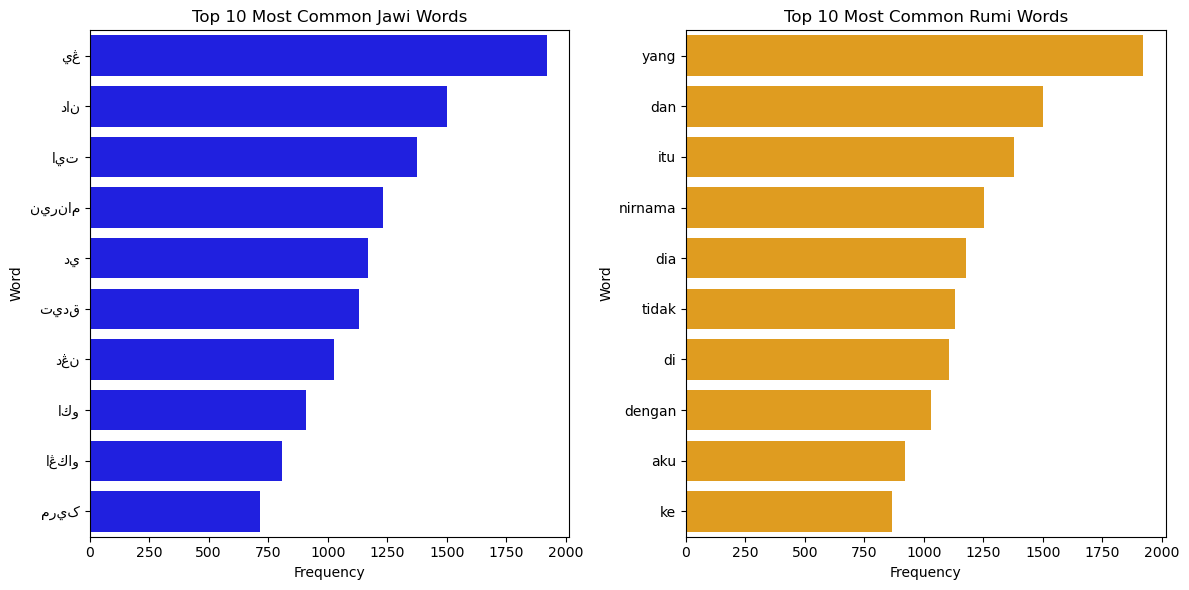

In [32]:
from collections import Counter

# Assuming jw_samples and rm_samples are the lists of Jawi and Rumi texts
jw_word_freq = Counter(" ".join(jw_samples).split())
rm_word_freq = Counter(" ".join(rm_samples).split())

# Get the most common and least common words
most_common_jw_words = jw_word_freq.most_common(10)
least_common_jw_words = jw_word_freq.most_common()[:-11:-1]

most_common_rm_words = rm_word_freq.most_common(10)
least_common_rm_words = rm_word_freq.most_common()[:-11:-1]

# Plot word frequency distributions
plt.figure(figsize=(12, 6))

# Jawi Word Frequency Distribution
plt.subplot(1, 2, 1)
sns.barplot(x=[word[1] for word in most_common_jw_words], y=[word[0] for word in most_common_jw_words], color='blue')
plt.title('Top 10 Most Common Jawi Words')
plt.xlabel('Frequency')
plt.ylabel('Word')

# Rumi Word Frequency Distribution
plt.subplot(1, 2, 2)
sns.barplot(x=[word[1] for word in most_common_rm_words], y=[word[0] for word in most_common_rm_words], color='orange')
plt.title('Top 10 Most Common Rumi Words')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.tight_layout()
plt.show()


In [33]:
print(most_common_jw_words)
print(most_common_rm_words)

[('يڠ', 1919), ('دان', 1501), ('ايت', 1376), ('نيرنام', 1233), ('دي', 1167), ('تيدق', 1130), ('دڠن', 1027), ('اكو', 909), ('اڠكاو', 806), ('مريک', 716)]
[('yang', 1921), ('dan', 1502), ('itu', 1378), ('nirnama', 1253), ('dia', 1175), ('tidak', 1132), ('di', 1106), ('dengan', 1028), ('aku', 921), ('ke', 866)]


C:\Users\aiman\AppData\Local\Temp\ipykernel_24688\2347579774.py:28: UserWarning: Glyph 1890 (\N{ARABIC LETTER KEHEH WITH DOT ABOVE}) missing from current font.
  plt.tight_layout()
C:\Users\aiman\AppData\Local\Temp\ipykernel_24688\2347579774.py:28: UserWarning: Glyph 1743 (\N{ARABIC LETTER WAW WITH DOT ABOVE}) missing from current font.
  plt.tight_layout()
C:\Users\aiman\AppData\Local\Temp\ipykernel_24688\2347579774.py:28: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
c:\Users\aiman\anaconda3\envs\tfgpu210\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1890 (\N{ARABIC LETTER KEHEH WITH DOT ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aiman\anaconda3\envs\tfgpu210\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1743 (\N{ARABIC LETTER WAW WITH DOT ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aiman\anaconda3\envs\tfgpu210\

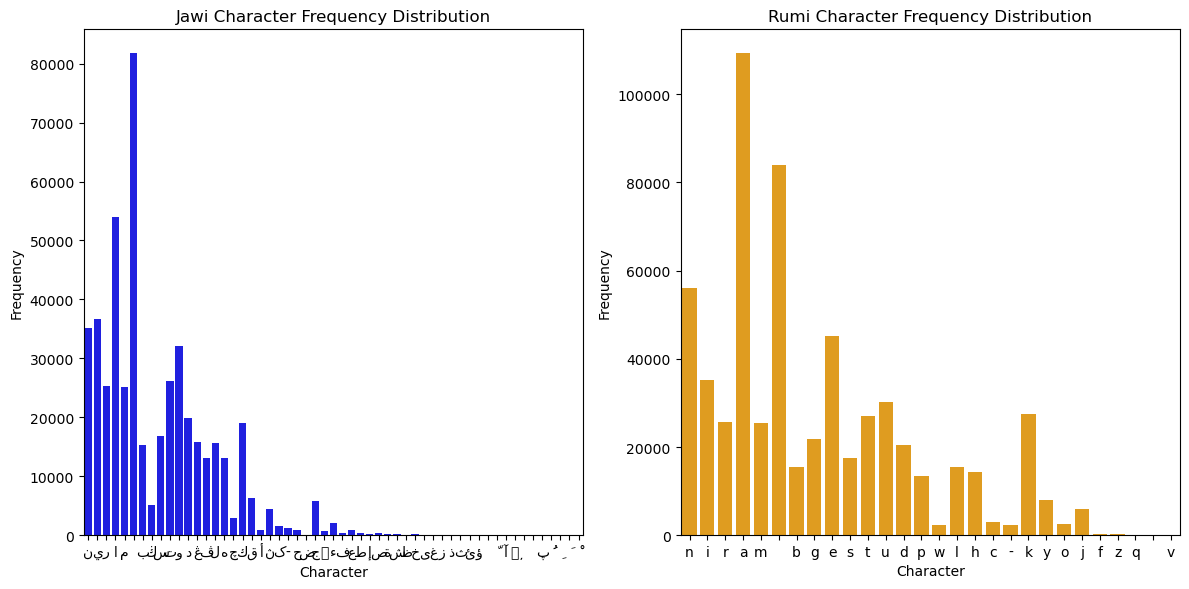

In [57]:
from collections import Counter

# Assuming jw_samples and rm_samples are the lists of Jawi and Rumi texts

jw_characters = list(" ".join(jw_samples))
rm_characters = list(" ".join(rm_samples))

jw_character_freq = Counter(jw_characters)
rm_character_freq = Counter(rm_characters)

plt.figure(figsize=(12, 6))


# Jawi Character Frequency Distribution
plt.subplot(1, 2, 1)
sns.barplot(x=list(jw_character_freq.keys()), y=list(jw_character_freq.values()), color='blue')
plt.title('Jawi Character Frequency Distribution')
plt.xlabel('Character')
plt.ylabel('Frequency')

# Rumi Character Frequency Distribution
plt.subplot(1, 2, 2)
sns.barplot(x=list(rm_character_freq.keys()), y=list(rm_character_freq.values()), color='orange')
plt.title('Rumi Character Frequency Distribution')
plt.xlabel('Character')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [66]:
# (rm_character_freq)
jw_character_freq

Counter({' ': 81736,
         'ا': 54046,
         'ي': 36759,
         'ن': 35166,
         'و': 32058,
         'ت': 26129,
         'ر': 25268,
         'م': 25102,
         'د': 19933,
         'ك': 19063,
         'س': 16759,
         'ڠ': 15775,
         'ل': 15621,
         'ب': 15291,
         'ڤ': 13149,
         'ه': 13104,
         'ق': 6376,
         'ج': 5854,
         'ڬ': 5096,
         'ڽ': 4440,
         'چ': 2883,
         'ء': 2074,
         'ک': 1518,
         '-': 1214,
         'ع': 959,
         'أ': 932,
         'ح': 896,
         'ݢ': 688,
         'ص': 395,
         'ط': 373,
         'ف': 298,
         'ة': 275,
         'إ': 246,
         'خ': 240,
         'ش': 173,
         'ض': 90,
         'ذ': 83,
         'ز': 67,
         'ى': 53,
         'ظ': 52,
         'غ': 18,
         'ِ': 18,
         'َ': 17,
         'ث': 14,
         'ّ': 14,
         'ئ': 8,
         'ُ': 6,
         '\u200c': 3,
         'ْ': 3,
         'ؤ': 1,
         'آ': 1,
        

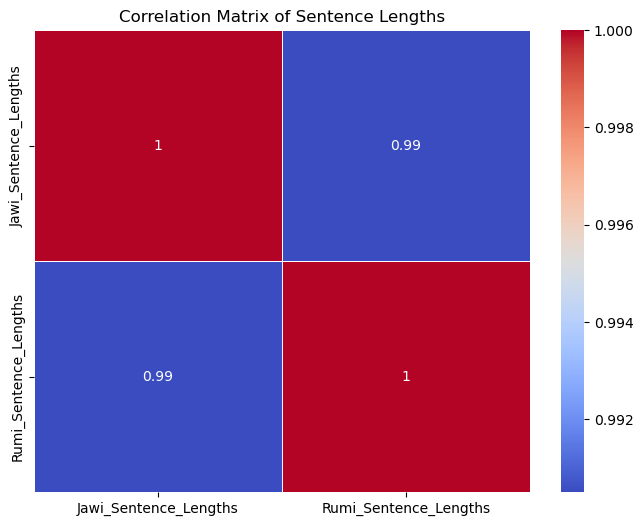

In [35]:
# Assuming jw_samples and rm_samples are the lists of Jawi and Rumi texts

jw_sentence_lengths = [len(sentence.split()) for sentence in jw_samples]
rm_sentence_lengths = [len(sentence.split()) for sentence in rm_samples]

import pandas as pd

# Create a DataFrame with relevant features
data = pd.DataFrame({
    'Jawi_Sentence_Lengths': jw_sentence_lengths,
    'Rumi_Sentence_Lengths': rm_sentence_lengths,
})

# Calculate correlation matrix
correlation_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Sentence Lengths')
plt.show()


In [52]:
from collections import Counter

# Assuming jw_samples and rm_samples are the lists of Jawi and Rumi texts

jw_word_freq = Counter(" ".join(jw_samples).split())
rm_word_freq = Counter(" ".join(rm_samples).split())


In [53]:
# Set a threshold for rare words (e.g., occurring only once)
rarity_threshold = 1

# Identify rare words
jw_rare_words = [word for word, freq in jw_word_freq.items() if freq <= rarity_threshold]
rm_rare_words = [word for word, freq in rm_word_freq.items() if freq <= rarity_threshold]


C:\Users\aiman\AppData\Local\Temp\ipykernel_24688\516318076.py:17: UserWarning: Glyph 1890 (\N{ARABIC LETTER KEHEH WITH DOT ABOVE}) missing from current font.
  plt.tight_layout()
C:\Users\aiman\AppData\Local\Temp\ipykernel_24688\516318076.py:17: UserWarning: Glyph 1743 (\N{ARABIC LETTER WAW WITH DOT ABOVE}) missing from current font.
  plt.tight_layout()
C:\Users\aiman\AppData\Local\Temp\ipykernel_24688\516318076.py:17: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
c:\Users\aiman\anaconda3\envs\tfgpu210\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1890 (\N{ARABIC LETTER KEHEH WITH DOT ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aiman\anaconda3\envs\tfgpu210\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 1743 (\N{ARABIC LETTER WAW WITH DOT ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aiman\anaconda3\envs\tfgpu210\lib

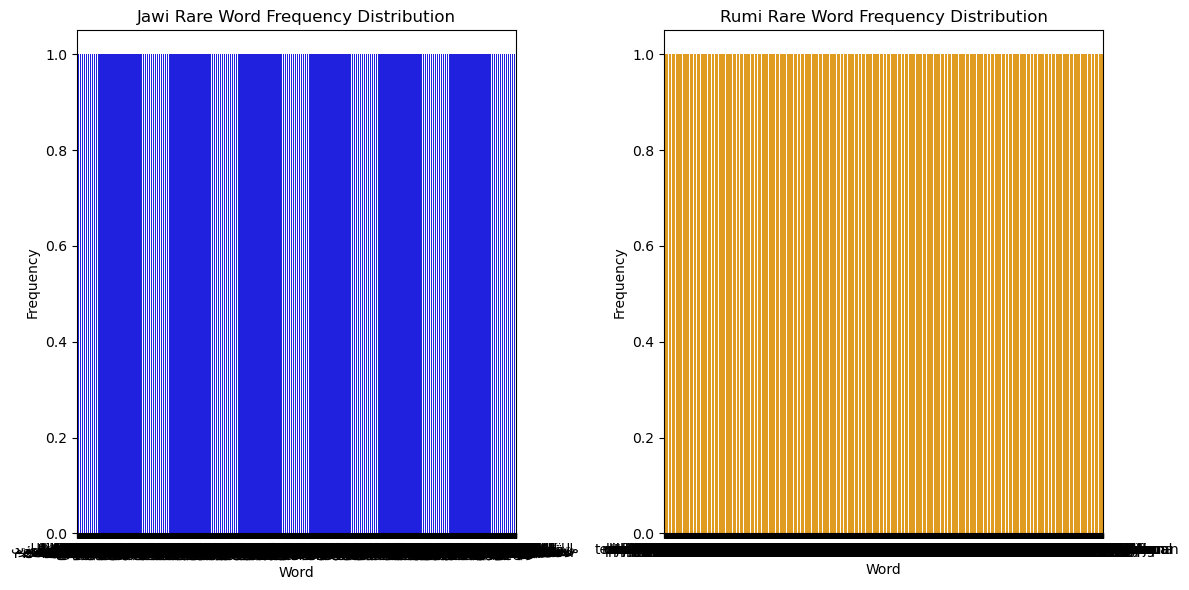

In [54]:
plt.figure(figsize=(12, 6))

# Jawi Rare Word Frequency Distribution
plt.subplot(1, 2, 1)
sns.barplot(x=jw_rare_words, y=[jw_word_freq[word] for word in jw_rare_words], color='blue')
plt.title('Jawi Rare Word Frequency Distribution')
plt.xlabel('Word')
plt.ylabel('Frequency')

# Rumi Rare Word Frequency Distribution
plt.subplot(1, 2, 2)
sns.barplot(x=rm_rare_words, y=[rm_word_freq[word] for word in rm_rare_words], color='orange')
plt.title('Rumi Rare Word Frequency Distribution')
plt.xlabel('Word')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Building the model

Defining the model
First need an embedding layer, i.e., a vector for every token in our input sequence.
This embedding layer can be initialised randomly. Also need a positional
embedding layer which encodes the word order in the sequence. The convention is
to add these two embeddings. KerasNLP has a `keras_nlp.layers.TokenAndPositionEmbedding `
layer which does all of the above steps for us.

The sequence-to-sequence Transformer consists of a `keras_nlp.layers.TransformerEncoder`
layer and a `keras_nlp.layers.TransformerDecoder` layer chained together.

The source sequence will be passed to `keras_nlp.layers.TransformerEncoder`, which
will produce a new representation of it. This new representation will then be passed
to the `keras_nlp.layers.TransformerDecoder`, together with the target sequence
so far (target words 0 to N). The `keras_nlp.layers.TransformerDecoder` will
then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking.
The `keras_nlp.layers.TransformerDecoder` sees the entire sequence at once, and
thus must make sure that it only uses information from target tokens 0 to N
when predicting token N+1 (otherwise, it could use information from the future,
which would result in a model that cannot be used at inference time). Causal masking
is enabled by default in `keras_nlp.layers.TransformerDecoder`.

Also need to mask the padding tokens (`"[PAD]"`). For this, we can set the
`mask_zero` argument of the `keras_nlp.layers.TokenAndPositionEmbedding` layer
to True. This will then be propagated to all subsequent layers.

In [36]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=JW_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=RM_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(RM_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="transformer",
)


In [37]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss in this case)
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
)

## Training our model


In [38]:
transformer.compile(
    "rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [39]:
transformer.summary()
# transformer.compile(
#     "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )
# transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding (  (None, None, 256)   3850240     ['encoder_inputs[0][0]']         
 TokenAndPositionEmbedding)                                                                       
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   1315072     ['token_and_position_em

In [40]:
history = transformer.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping],
)

Epoch 1/30
149/149 [==============================] - 20s 88ms/step - loss: 1.9664 - accuracy: 0.2424 - val_loss: 1.4576 - val_accuracy: 0.3756
Epoch 2/30
149/149 [==============================] - 12s 79ms/step - loss: 1.2343 - accuracy: 0.4799 - val_loss: 1.0079 - val_accuracy: 0.5634
Epoch 3/30
149/149 [==============================] - 12s 80ms/step - loss: 0.8786 - accuracy: 0.6136 - val_loss: 0.7769 - val_accuracy: 0.6554
Epoch 4/30
149/149 [==============================] - 13s 84ms/step - loss: 0.6524 - accuracy: 0.7004 - val_loss: 0.6436 - val_accuracy: 0.7042
Epoch 5/30
149/149 [==============================] - 12s 83ms/step - loss: 0.5007 - accuracy: 0.7615 - val_loss: 0.5647 - val_accuracy: 0.7364
Epoch 6/30
149/149 [==============================] - 12s 83ms/step - loss: 0.3927 - accuracy: 0.8051 - val_loss: 0.5176 - val_accuracy: 0.7589
Epoch 7/30
149/149 [==============================] - 12s 83ms/step - loss: 0.3169 - accuracy: 0.8378 - val_loss: 0.4873 - val_accuracy:

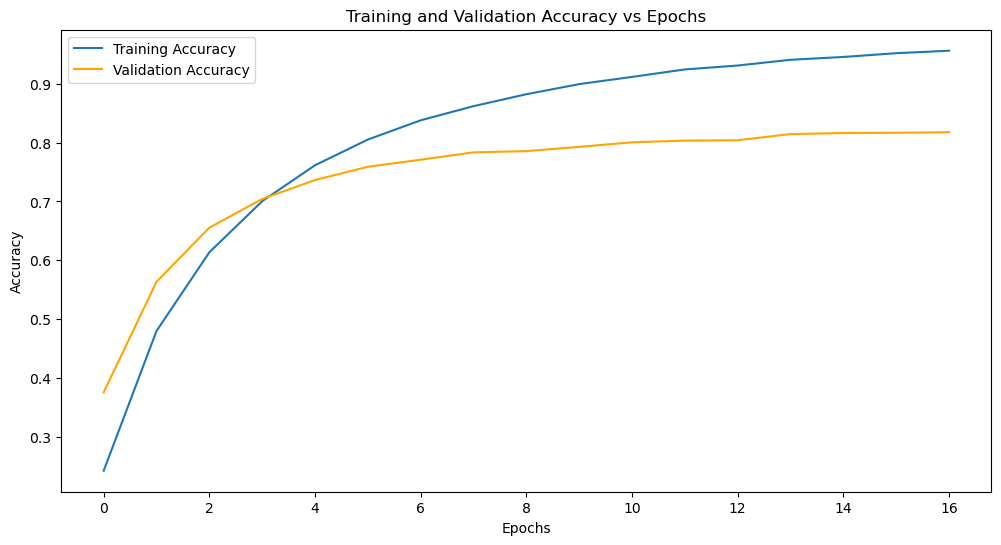

In [41]:
import numpy as np

# Save training and validation accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.plot(train_accuracy, label='Training Accuracy')
# Plot validation accuracy on the same graph
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Save training and validation accuracy for later use
np.save('val_accuracy.npy', val_accuracy)
np.save('train_accuracy.npy', train_accuracy)

# ... (rest of your existing code)

In [42]:
# Save the entire model
transformer.save("transformer_model")


INFO:tensorflow:Assets written to: transformer_model\assets


INFO:tensorflow:Assets written to: transformer_model\assets


In [43]:
# Load the model
loaded_model = keras.models.load_model("transformer_model")


## Decoding test sentences (qualitative analysis)

Finally, let's demonstrate how to translate brand new Jawi sentences.
Simply feed into the model the tokenized Jawi sentence
as well as the target token `"[START]"`. The model outputs probabilities of the
next token. We then we repeatedly generated the next token conditioned on the
tokens generated so far, until we hit the token `"[END]"`.

For decoding, we will use the `keras_nlp.samplers` module from
KerasNLP. Greedy Decoding is a text decoding method which outputs the most
likely next token at each time step, i.e., the token with the highest probability.

In [44]:

def decode_sequences(input_sentences):
    batch_size = tf.shape(input_sentences)[0]

    # Tokenize the encoder input.
    encoder_input_tokens = jw_tokenizer(input_sentences).to_tensor(
        shape=(None, MAX_SEQUENCE_LENGTH)
    )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def next(prompt, cache, index):
        logits = loaded_model([encoder_input_tokens, prompt])[:, index - 1, :]
        # Ignore hidden states for now; only needed for contrastive search.
        hidden_states = None
        return logits, hidden_states, cache

    # Build a prompt of length 40 with a start token and padding tokens.
    length = 40
    start = tf.fill((batch_size, 1), rm_tokenizer.token_to_id("[START]"))
    pad = tf.fill((batch_size, length - 1), rm_tokenizer.token_to_id("[PAD]"))
    prompt = tf.concat((start, pad), axis=-1)

    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        end_token_id=rm_tokenizer.token_to_id("[END]"),
        index=1,  # Start sampling after start token.
    )
    generated_sentences = rm_tokenizer.detokenize(generated_tokens)
    return generated_sentences


test_jw_texts = [pair[0] for pair in test_pairs]
for i in range(20):
    input_sentence = random.choice(test_jw_texts)
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8")
    # translated = (
    #     translated.replace("[PAD]", "")
    #     .replace("[START]", "")
    #     .replace("[END]", "")
    #     .strip()
    # )
    print(f"** Example {i} **")
    print(input_sentence)
    print(translated)
    print()

** Example 0 **
اسڤ بركڤول-كڤول باڬايكن ترڤنچوت دري بلاكڠ توبوه ڤوترا سراڤي سمبيل للاكي ايت منجريت-جريت كساكيتن
[START] asap berkepul - kepul bagaikan terpepanc dari belakang tubuh putera serapi sambil menjerit lelaki itu menjerit - jerit kesakitan [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

** Example 1 **
توانكو سلطان محمود بڬيتو ماهو مراڤتيكو
[START] tuanku sultan mahmud begitu mahu merapatiku [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

** Example 2 **
بهكن سلاما اين كاميله يڠ چوبا مڠكڠ سيكڤ دان ڤربواتن توانكو سلطان محمود
[START] bahkan selama ini kamilah yang cuba mengekang dan perbuatan tuanku sultan mahmud [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

** Example 3 **
اورڠ راماي مڠلواركن سوارا كچيوا
[START] orang r

In [45]:
# Assuming your test dataset is named test_ds
test_results = transformer.evaluate(test_ds)

# The evaluate method returns a list of metrics, you can print or use them as needed
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


32/32 [==============================] - 2s 38ms/step - loss: 0.4697 - accuracy: 0.8101
Test Loss: 0.4697166383266449
Test Accuracy: 0.8100989460945129


32/32 [==============================] - 1s 35ms/step - loss: 0.4697 - accuracy: 0.8101


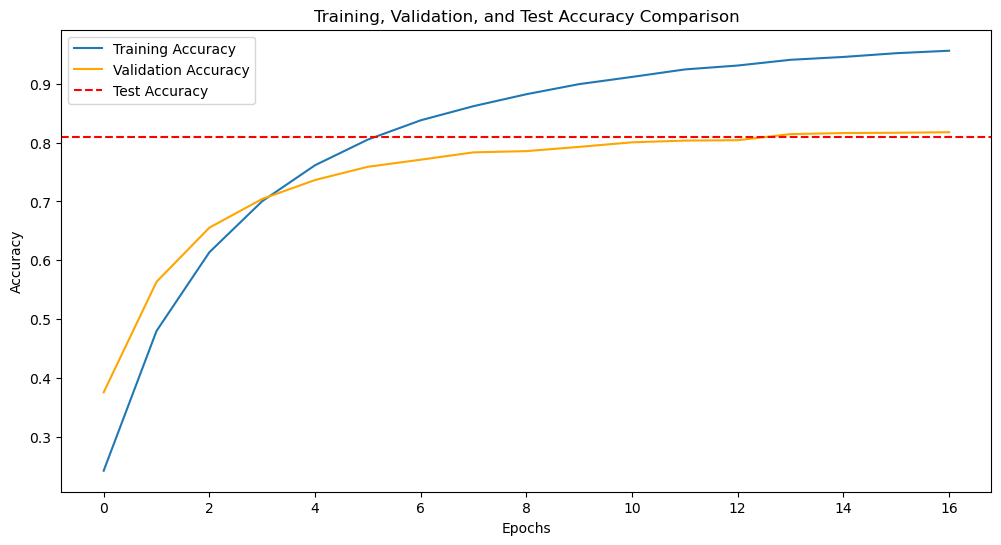

In [46]:
# import numpy as np

# Load training and validation accuracy values
train_accuracy = np.load('train_accuracy.npy')
val_accuracy = np.load('val_accuracy.npy')

# Plot training, validation, and test accuracy on the same graph
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Evaluate the model on the test dataset and plot the result
test_results = transformer.evaluate(test_ds)
test_accuracy = test_results[1]
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')

plt.title('Training, Validation, and Test Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


** Example 0 **
Predicted Translation: turun kepepan utama
Reference Translation: turun ke pentas utama
Total Correct Predictions: 0

** Example 1 **
Predicted Translation: tetapi benar - benar bersih nit nit inimu diri untuknya daripada cengkaman dan as dan usi jagat suci
Reference Translation: tetapi benar - benar bersihlah niatmu untuk membebaskan tanah ini daripada cengkaman dan anasir jagat suci
Total Correct Predictions: 0

** Example 2 **
Predicted Translation: nirnama membebaskan kami daripada cengkaman bagak durjana
Reference Translation: nirnama membebaskan kami daripada cengkaman bagak durjana
Total Correct Predictions: 1

** Example 3 **
Predicted Translation: pak kaduk hanya marha yang hidupnya selama ini selama ini
Reference Translation: pak kaduk hanya marhaen yang hidupnya selama ini cukup makan sahaja
Total Correct Predictions: 1

** Example 4 **
Predicted Translation: wajah puteri santubong sentiasa sentiasa mengegang
Reference Translation: wajah puteri santubong sent

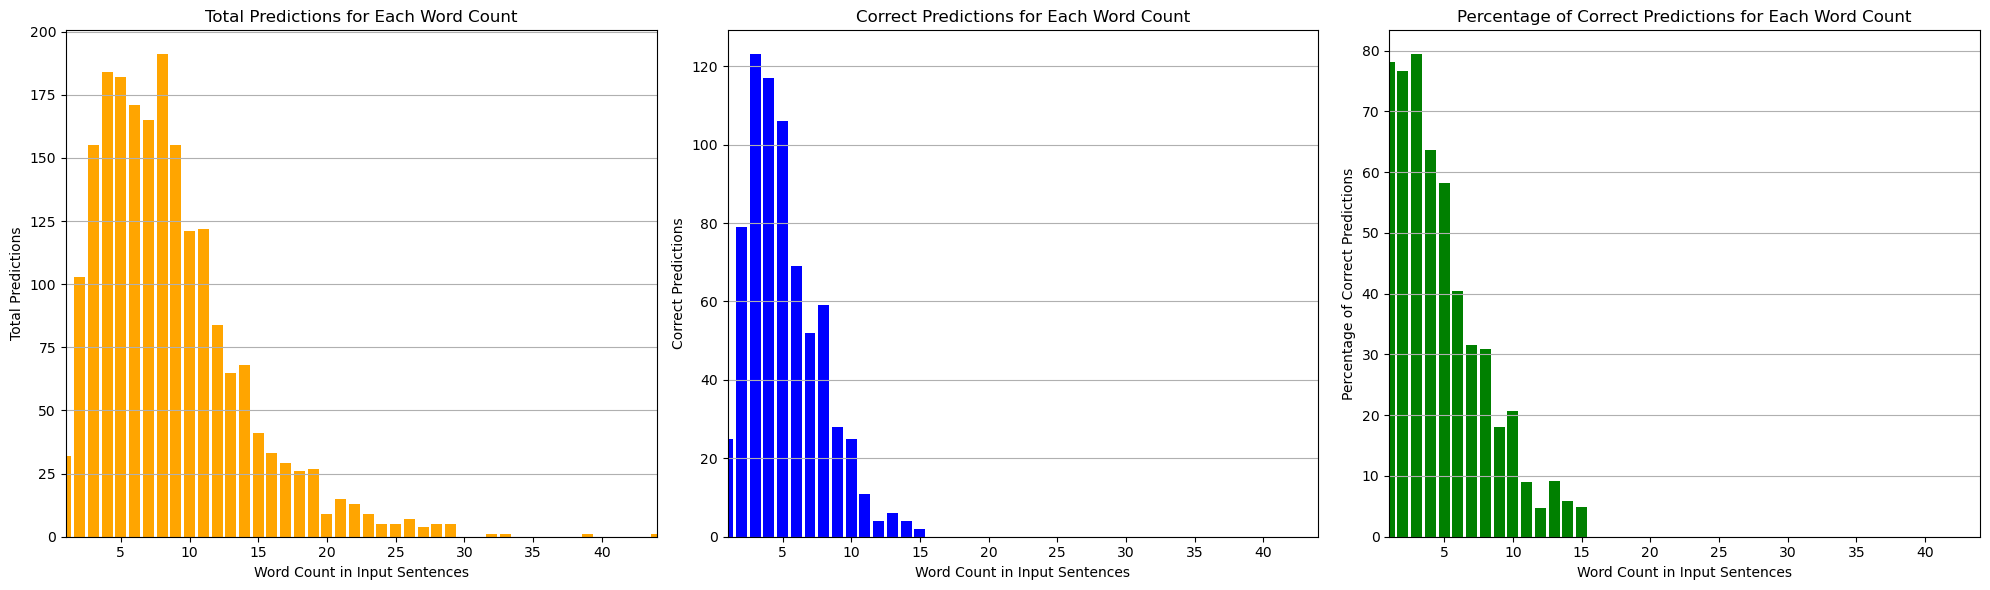

In [47]:
import matplotlib.pyplot as plt
from collections import defaultdict

test_jw_texts = [pair[0] for pair in test_pairs]
test_rm_texts = [pair[1] for pair in test_pairs]

# Tokenize each sentence in test_rm_texts
test_rm_tokens = [rm_tokenizer.tokenize(sentence) for sentence in test_rm_texts]

# Detokenize and preprocess each sentence in the list
test_rm_detokenized = [
    rm_tokenizer.detokenize(tokens).numpy().decode("utf-8").replace("[PAD]", "").replace("[START]", "").replace("[END]", "").strip()
    for tokens in test_rm_tokens
]
# ... (your existing code)

correct_predictions = 0
correct_predictions_by_word_count = defaultdict(int)
total_predictions_by_word_count = defaultdict(int)

for i, input_sentence in enumerate(test_jw_texts):
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8").replace("[PAD]", "").replace("[START]", "").replace("[END]", "").strip()

    reference = test_rm_detokenized[i]
    word_count = len(input_sentence.split())

    total_predictions_by_word_count[word_count] += 1

    print(f"** Example {i} **")
    print("Predicted Translation:", translated)
    print("Reference Translation:", reference)

    if translated == reference:
        correct_predictions += 1
        correct_predictions_by_word_count[word_count] += 1

    print("Total Correct Predictions:", correct_predictions)
    print()

# Calculate accuracy
accuracy = correct_predictions / len(test_jw_texts) * 100
print(f"Accuracy: {accuracy:.2f}%")

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# Plot 1: Total Predictions for Each Word Count
axs[0].bar(list(total_predictions_by_word_count.keys()), list(total_predictions_by_word_count.values()), color='orange')
axs[0].set_title('Total Predictions for Each Word Count')
axs[0].set_xlabel('Word Count in Input Sentences')
axs[0].set_ylabel('Total Predictions')
axs[0].grid(axis='y')

# Plot 2: Correct Predictions for Each Word Count
axs[1].bar(list(correct_predictions_by_word_count.keys()), list(correct_predictions_by_word_count.values()), color='blue')
axs[1].set_title('Correct Predictions for Each Word Count')
axs[1].set_xlabel('Word Count in Input Sentences')
axs[1].set_ylabel('Correct Predictions')
axs[1].grid(axis='y')

# Plot 3: Percentage of Correct Predictions for Each Word Count
percentage_correct_by_word_count = {
    word_count: (correct_predictions_by_word_count[word_count] / total_predictions_by_word_count[word_count]) * 100
    for word_count in total_predictions_by_word_count
}
axs[2].bar(list(percentage_correct_by_word_count.keys()), list(percentage_correct_by_word_count.values()), color='green')
axs[2].set_title('Percentage of Correct Predictions for Each Word Count')
axs[2].set_xlabel('Word Count in Input Sentences')
axs[2].set_ylabel('Percentage of Correct Predictions')
axs[2].grid(axis='y')

# Set x-axis limits to be the same for all subplots
min_x_value = min(
    min(total_predictions_by_word_count.keys()),
    min(correct_predictions_by_word_count.keys()),
    min(percentage_correct_by_word_count.keys())
)
max_x_value = max(
    max(total_predictions_by_word_count.keys()),
    max(correct_predictions_by_word_count.keys()),
    max(percentage_correct_by_word_count.keys())
)

for ax in axs:
    ax.set_xlim(min_x_value, max_x_value)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [48]:


total_words = 0
total_correct_words = 0

for i, input_sentence in enumerate(test_jw_texts):
    translated = decode_sequences(tf.constant([input_sentence]))
    translated = translated.numpy()[0].decode("utf-8").replace("[PAD]", "").replace("[START]", "").replace("[END]", "").strip()

    reference = test_rm_detokenized[i]

    print(f"** Example {i} **")
    print("Input Sentence:", input_sentence)

    # Tokenize the predicted and reference translations
    predicted_tokens = rm_tokenizer.tokenize(translated).numpy()  # Convert to numpy array
    reference_tokens = rm_tokenizer.tokenize(reference).numpy()  # Convert to numpy array

    # Detokenize to get the actual words
    predicted_words = rm_tokenizer.detokenize(predicted_tokens).numpy().decode("utf-8").split()
    reference_words = rm_tokenizer.detokenize(reference_tokens).numpy().decode("utf-8").split()

    # Print current prediction and reference side by side
    for p, r in zip(predicted_words, reference_words):
        print(f"Current Prediction: {p}\tReference: {r}")

    # Debugging information
    # print("Predicted Tokens:", predicted_tokens)
    # print("Reference Tokens:", reference_tokens)
    print("Predicted Words:", predicted_words)
    print("Reference Words:", reference_words)

    # Calculate word-level accuracy for the example
    correct_predictions = sum(p == r for p, r in zip(predicted_tokens, reference_tokens))
    word_level_accuracy = (correct_predictions / len(reference_tokens)) * 100
    print(f"Word-level Accuracy: {word_level_accuracy:.2f}%")

    total_correct_words += correct_predictions
    total_words += len(reference_tokens)

    print()

# Calculate overall word-level accuracy
overall_word_level_accuracy = (total_correct_words / total_words) * 100
print(f"Overall Word-level Accuracy: {overall_word_level_accuracy:.2f}%")


** Example 0 **
Input Sentence: تورون كڤنتس اوتام
Current Prediction: turun	Reference: turun
Current Prediction: kepepan	Reference: ke
Current Prediction: utama	Reference: pentas
Predicted Words: ['turun', 'kepepan', 'utama']
Reference Words: ['turun', 'ke', 'pentas', 'utama']
Word-level Accuracy: 66.67%

** Example 1 **
Input Sentence: تتاڤي بنر برسيهله نيتمو اونتوق ممبيبسكن تانه اين درڤد چڠكمن دان عناصير جاڬت سوچي
Current Prediction: tetapi	Reference: tetapi
Current Prediction: benar	Reference: benar
Current Prediction: -	Reference: -
Current Prediction: benar	Reference: benar
Current Prediction: bersih	Reference: bersihlah
Current Prediction: nit	Reference: niatmu
Current Prediction: nit	Reference: untuk
Current Prediction: inimu	Reference: membebaskan
Current Prediction: diri	Reference: tanah
Current Prediction: untuknya	Reference: ini
Current Prediction: daripada	Reference: daripada
Current Prediction: cengkaman	Reference: cengkaman
Current Prediction: dan	Reference: dan
Current P